# Unit 5 - Financial Planning

In [1]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import json
import numpy as np

%matplotlib inline

In [2]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [3]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3


In [4]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [5]:
# # Fetch current BTC price
btc_price = requests.get(btc_url).json()
btc_price = btc_price['data']['1']['quotes']['CAD']['price']
# # Fetch current ETH price
eth_price = requests.get(eth_url).json()
eth_price = eth_price['data']['1027']['quotes']['CAD']['price']
# Compute current value of my crpto
my_btc_value = my_btc*btc_price
my_eth_value = my_eth*eth_price

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $43884.98
The current value of your 5.3 ETH is $12050.58


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [6]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [7]:
# Set Alpaca API key and secret
# Create the Alpaca API object

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")


api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

In [14]:
# Format current date as ISO format due to api erroring on current date fetching data from last year
start_date = pd.Timestamp("2023-09-29", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2023-09-29", tz="America/New_York").isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

# Get current closing prices for SPY and AGG
ticker_data = api.get_bars(tickers,
                           timeframe,
                           start= start_date,
                           end= end_date).df
# Reorganize the DataFrame
AGG = ticker_data[ticker_data["symbol"]=="AGG"].drop("symbol", axis=1)
SPY = ticker_data[ticker_data["symbol"]=="SPY"].drop("symbol", axis=1)



# Concatenate the ticker DataFrames
df_new = pd.concat([AGG,SPY], axis=1, keys=['AGG','SPY'])

# Preview DataFrame
df_new.head()

AGG                                              \
                           open    high    low  close    volume trade_count   
timestamp                                                                     
2023-09-29 04:00:00+00:00  94.5  94.565  93.97  94.04  13483638       32219   

                                         SPY                          \
                                vwap    open    high     low   close   
timestamp                                                              
2023-09-29 04:00:00+00:00  94.180846  431.67  431.85  425.91  427.48   

                                                              
                              volume trade_count        vwap  
timestamp                                                     
2023-09-29 04:00:00+00:00  115110527      745028  428.510183

In [23]:
# Pick AGG and SPY close prices
agg_close_price = df_new['AGG']['close'].iloc[0]
spy_close_price = df_new['SPY']['close'].iloc[0]
# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $94.04
Current SPY closing price: $427.48


In [24]:
# Compute the current value of shares
my_agg_value =  my_agg* agg_close_price
my_spy_value =  my_spy * spy_close_price
# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $21374.00
The current value of your 200 AGG shares is $18808.00


### Savings Health Analysis

In [27]:
# Set monthly household income
monthly_income = 12000
# Consolidate financial assets data
data = {'Asset': ['crypto','shares'], 'amount':[(my_btc_value+my_eth_value),(my_agg_value+my_spy_value)]}

# Create savings DataFrame
df_savings = pd.DataFrame(data)
df_savings.set_index('Asset',inplace=True)

# Display savings DataFrame
display(df_savings)

amount
Asset               
crypto  55935.563684
shares  40182.000000

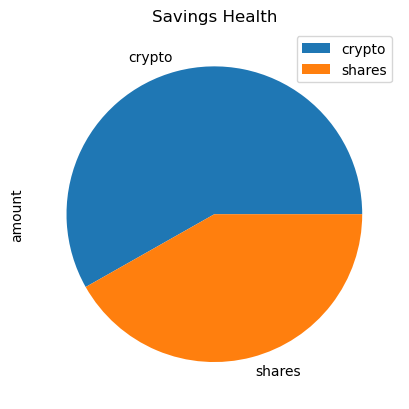

In [34]:
# Plot savings pie chart
df_savings.plot.pie(y='amount', title="Savings Health");

In [45]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
savings = df_savings['amount'].sum()
# Validate saving health
if df_savings['amount'].sum() > emergency_fund:
    print(f"Congratulation your savings are higher than your goal by {round(df_savings['amount'].sum()-emergency_fund,2)}")
elif df_savings['amount'].sum()==emergency_fund:
    print(f"Congratulation you have met your goal savings")
else:
    print(f"NEED TO SAVE MORE MONEY CURRENTLY {round(df_savings['amount'].sum()-emergency_fund,2)} much away from target")

Congratulation your savings are higher than your goal by 60117.56


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [47]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date_5y = pd.Timestamp('2016-05-01', tz='America/New_York').isoformat()
end_date_5y = pd.Timestamp('2021-05-01', tz='America/New_York').isoformat()

In [54]:
# Get 5 years' worth of historical data for SPY and AGG
ticker_data_5y = api.get_bars(tickers,
                           timeframe,
                           start= start_date_5y,
                           end= end_date_5y).df
# Reorganize the DataFrame
# Separate ticker data
AGG_5y = ticker_data_5y[ticker_data_5y["symbol"]=="AGG"].drop("symbol", axis=1)
SPY_5y = ticker_data_5y[ticker_data_5y["symbol"]=="SPY"].drop("symbol", axis=1)



# Concatenate the ticker DataFrames
df_new_5y = pd.concat([AGG_5y,SPY_5y], axis=1, keys=['AGG','SPY'])

# Preview DataFrame
df_new_5y.sample(10)

AGG                                      \
                             open      high      low   close   volume   
timestamp                                                               
2016-10-26 04:00:00+00:00  111.57  111.5701  111.430  111.44  2684013   
2018-05-07 04:00:00+00:00  105.88  105.8800  105.770  105.81  1533669   
2019-10-30 04:00:00+00:00  112.45  112.7500  112.430  112.71  2381436   
2016-11-21 05:00:00+00:00  108.56  108.5700  108.370  108.46  1705567   
2020-12-15 05:00:00+00:00  117.95  118.0300  117.900  118.03  4217872   
2019-02-27 05:00:00+00:00  107.40  107.4000  107.210  107.26  2990107   
2016-07-11 04:00:00+00:00  113.19  113.2400  112.930  112.95  4423995   
2018-05-23 04:00:00+00:00  105.50  105.6500  105.480  105.60  6061860   
2017-12-01 05:00:00+00:00  109.02  109.4800  108.845  109.16  3331338   
2018-12-12 05:00:00+00:00  105.48  105.5688  105.460  105.50  8089056   

                                                      SPY                  \
                          trade_count        vwap    open    high     low   
timestamp                                                                   
2016-10-26 04:00:00+00:00       10187  111.485367  213.21  214.42  212.93   
2018-05-07 04:00:00+00:00        7643  105.816832  266.89  268.02  266.11   
2019-10-30 04:00:00+00:00       10905  112.599741  303.43  304.55  301.99   
2016-11-21 05:00:00+00:00        8768  108.456637  219.17  220.18  219.00   
2020-12-15 05:00:00+00:00       16066  117.969598  367.40  369.59  365.92   
2019-02-27 05:00:00+00:00       13458  107.280326  278.52  279.59  277.48   
2016-07-11 04:00:00+00:00       12595  113.043355  213.19  214.07  212.95   
2018-05-23 04:00:00+00:00       14076  105.536087  271.17  273.39  270.99   
2017-12-01 05:00:00+00:00       17169  109.190890  264.76  265.31  260.76   
2018-12-12 05:00:00+00:00       15117  105.520768  267.47  269.00  265.37   

                                                                      
                            close     volume trade_count        vwap  
timestamp                                                             
2016-10-26 04:00:00+00:00  213.75   75700438      275553  213.722444  
2018-05-07 04:00:00+00:00  266.92   56495099      242699  267.100589  
2019-10-30 04:00:00+00:00  304.21   49656116      283053  303.314254  
2016-11-21 05:00:00+00:00  220.12   72402638      249611  219.692453  
2020-12-15 05:00:00+00:00  369.56   64071099      285593  367.839808  
2019-02-27 05:00:00+00:00  279.18   56936701      275536  278.798707  
2016-07-11 04:00:00+00:00  213.40   73601937      268251  213.553877  
2018-05-23 04:00:00+00:00  273.37   64699784      244213  272.208737  
2017-12-01 05:00:00+00:00  264.46  161828840      618108  263.742715  
2018-12-12 05:00:00+00:00  265.53   98227166      512843  266.947703

In [55]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_30_return = MCSimulation(portfolio_data=df_new_5y,weights=[.4,.6],num_simulation=500,num_trading_days=252*30)

                            
                    

In [57]:
# Printing the simulation input data
MC_30_return.portfolio_data.head()

AGG                                        \
                             open      high       low    close   volume   
timestamp                                                                 
2016-05-02 04:00:00+00:00  110.74  110.7400  110.5200  110.605  3553939   
2016-05-03 04:00:00+00:00  110.89  110.9450  110.7500  110.810  3044940   
2016-05-04 04:00:00+00:00  110.91  110.9315  110.7595  110.860  2920608   
2016-05-05 04:00:00+00:00  110.92  111.1600  110.8010  111.140  3008142   
2016-05-06 04:00:00+00:00  111.12  111.1200  110.9700  110.970  2718710   

                                                                   SPY  \
                          trade_count        vwap daily_return    open   
timestamp                                                                
2016-05-02 04:00:00+00:00       15119  110.627199          NaN  206.92   
2016-05-03 04:00:00+00:00       15662  110.865995     0.001853  206.52   
2016-05-04 04:00:00+00:00       13982  110.879063     0.000451  204.99   
2016-05-05 04:00:00+00:00       15707  111.028363     0.002526  205.56   
2016-05-06 04:00:00+00:00       12697  111.031967    -0.001530  204.08   

                                                                            \
                             high     low     close     volume trade_count   
timestamp                                                                    
2016-05-02 04:00:00+00:00  208.18  206.41  207.9700   61908515      263580   
2016-05-03 04:00:00+00:00  206.80  205.28  206.1592  106422142      377518   
2016-05-04 04:00:00+00:00  205.85  204.42  205.0100   92199810      345261   
2016-05-05 04:00:00+00:00  205.98  204.47  204.9700   67597222      280622   
2016-05-06 04:00:00+00:00  205.77  203.88  205.7200   89131004      340335   

                                                    
                                 vwap daily_return  
timestamp                                           
2016-05-02 04:00:00+00:00  207.294812          NaN  
2016-05-03 04:00:00+00:00  206.312060    -0.008707  
2016-05-04 04:00:00+00:00  205.090172    -0.005574  
2016-05-05 04:00:00+00:00  205.141555    -0.000195  
2016-05-06 04:00:00+00:00  204.937074     0.003659

In [58]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_30_return.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: Perfo

Running Monte Carlo simulation number 110.


/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: Perfo

Running Monte Carlo simulation number 120.


/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: Perfo

Running Monte Carlo simulation number 130.


/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: Perfo

Running Monte Carlo simulation number 140.


/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: Perfo

Running Monte Carlo simulation number 150.


/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: Perfo

Running Monte Carlo simulation number 160.


/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: Perfo

Running Monte Carlo simulation number 170.


/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: Perfo

Running Monte Carlo simulation number 180.


/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: Perfo

Running Monte Carlo simulation number 190.


/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: Perfo

Running Monte Carlo simulation number 200.


/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: Perfo

Running Monte Carlo simulation number 210.


/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: Perfo

Running Monte Carlo simulation number 220.


/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: Perfo

Running Monte Carlo simulation number 230.


/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: Perfo

Running Monte Carlo simulation number 240.


/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: Perfo

Running Monte Carlo simulation number 250.


/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: Perfo

Running Monte Carlo simulation number 260.


/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: Perfo

Running Monte Carlo simulation number 270.


/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: Perfo

Running Monte Carlo simulation number 280.


/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: Perfo

Running Monte Carlo simulation number 290.


/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: Perfo

Running Monte Carlo simulation number 300.


/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: Perfo

Running Monte Carlo simulation number 310.


/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: Perfo

Running Monte Carlo simulation number 320.


/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: Perfo

Running Monte Carlo simulation number 330.


/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: Perfo

Running Monte Carlo simulation number 340.


/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: Perfo

Running Monte Carlo simulation number 350.


/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: Perfo

Running Monte Carlo simulation number 360.


/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: Perfo

Running Monte Carlo simulation number 370.


/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: Perfo

Running Monte Carlo simulation number 380.


/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: Perfo

Running Monte Carlo simulation number 390.


/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: Perfo

Running Monte Carlo simulation number 400.


/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: Perfo

Running Monte Carlo simulation number 410.


/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: Perfo

Running Monte Carlo simulation number 420.


/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: Perfo

Running Monte Carlo simulation number 430.


/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: Perfo

Running Monte Carlo simulation number 440.


/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: Perfo

Running Monte Carlo simulation number 450.


/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: Perfo

Running Monte Carlo simulation number 460.


/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: Perfo

Running Monte Carlo simulation number 470.


/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: Perfo

Running Monte Carlo simulation number 480.


/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: Perfo

Running Monte Carlo simulation number 490.


/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/FIntech_consulting/Starter_Code/MCForecastTools.py:117: Perfo

0          1          2          3          4          5    \
0      1.000000   1.000000   1.000000   1.000000   1.000000   1.000000   
1      1.005468   1.002542   0.997654   1.012503   1.002586   1.006872   
2      1.007473   1.005110   1.006183   1.015580   0.999985   0.997671   
3      0.997975   1.003987   1.013791   1.017013   0.992968   0.999095   
4      0.996185   0.992434   1.016951   1.029027   1.000779   0.993184   
...         ...        ...        ...        ...        ...        ...   
7556  24.615980  11.084481  10.640659  28.098832  10.660110  51.275680   
7557  24.687750  11.079589  10.630304  28.015557  10.629570  51.868770   
7558  24.852730  11.107000  10.656713  28.011146  10.630412  52.152046   
7559  24.933892  11.099288  10.617763  28.004634  10.614788  52.662176   
7560  24.980426  11.114096  10.597313  27.938640  10.606041  52.699078   

            6          7         8          9    ...       490        491  \
0      1.000000   1.000000  1.000000   1.000000  ...  1.000000   1.000000   
1      1.002670   0.999760  1.011026   0.990335  ...  1.002880   1.002498   
2      1.019584   1.004612  1.000426   0.982665  ...  1.011562   0.997861   
3      1.024823   1.005519  1.006471   0.988534  ...  1.011478   0.988862   
4      1.025368   1.004291  1.016160   0.981180  ...  1.010340   0.998101   
...         ...        ...       ...        ...  ...       ...        ...   
7556  11.473739  11.649324  9.524848  11.903469  ...  7.595124  16.304596   
7557  11.474610  11.736179  9.572554  12.026928  ...  7.567609  16.148882   
7558  11.570990  11.631805  9.520242  11.863120  ...  7.584599  16.113919   
7559  11.536946  11.578772  9.531065  11.823390  ...  7.616530  16.171318   
7560  11.474331  11.478125  9.579921  11.810502  ...  7.603824  16.224205   

            492        493        494        495        496        497  \
0      1.000000   1.000000   1.000000   1.000000   1.000000   1.000000   
1      0.998096   1.000018   0.986962   0.998227   1.001185   0.998098   
2      1.007875   1.004100   0.980786   0.994192   0.977010   1.007878   
3      1.004611   1.004650   0.976688   1.003453   0.972179   1.006599   
4      1.004541   1.004772   0.982913   1.011883   0.971915   1.012727   
...         ...        ...        ...        ...        ...        ...   
7556  49.798572  45.144366  13.197655  27.282915  37.409260  12.687885   
7557  50.244523  45.019056  13.272234  27.027773  37.357958  12.664318   
7558  49.546366  44.963447  13.173089  27.047559  37.303217  12.772331   
7559  49.877139  45.024317  13.035090  26.839670  37.343384  12.733105   
7560  49.638235  45.349572  13.178817  26.686335  37.455095  12.732476   

            498        499  
0      1.000000   1.000000  
1      0.999393   1.001649  
2      1.003299   0.993895  
3      0.996468   0.995906  
4      0.991971   0.988045  
...         ...        ...  
7556  12.672433  52.027618  
7557  12.707803  52.114946  
7558  12.856950  52.001335  
7559  12.856040  51.611464  
7560  12.703464  51.385924  

[7561 rows x 500 columns]

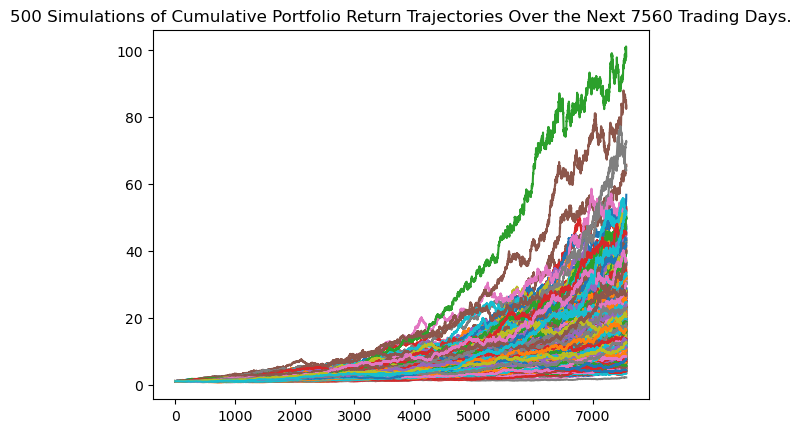

In [60]:
# Plot simulation outcomes
MC_30_return.plot_simulation();

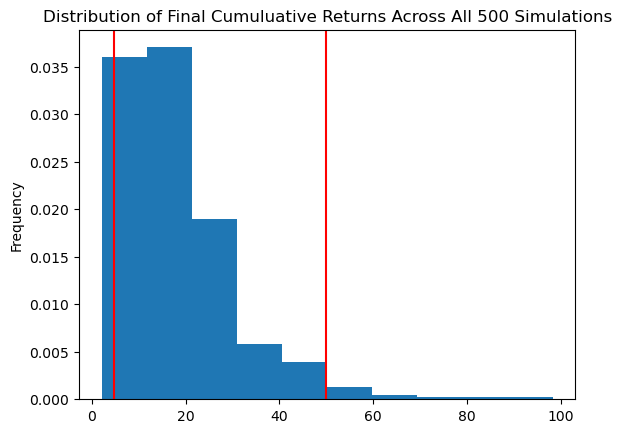

In [62]:
# Plot probability distribution and confidence intervals
MC_30_return.plot_distribution();

### Retirement Analysis

In [63]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_30_return.summarize_cumulative_return()

# Print summary statistics
tbl

count           500.000000
mean             18.103197
std              12.140552
min               2.137037
25%               9.855306
50%              14.469451
75%              23.128400
max              98.220734
95% CI Lower      4.859584
95% CI Upper     49.885840
Name: 7560, dtype: float64

### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [64]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(tbl[8]*initial_investment,2)
ci_upper = round(tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $97191.68 and $997716.8


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [65]:
# Set initial investment
initial_investment_2 = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(tbl[8]*initial_investment_2,2)
ci_upper = round(tbl[9]*initial_investment_2,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment_2} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $145787.52 and $1496575.19


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [ ]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
# YOUR CODE HERE!

In [ ]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
# YOUR CODE HERE!

In [ ]:
# Plot simulation outcomes
# YOUR CODE HERE!

In [ ]:
# Plot probability distribution and confidence intervals
# YOUR CODE HERE!

In [ ]:
# Fetch summary statistics from the Monte Carlo simulation results
# YOUR CODE HERE!

# Print summary statistics
# YOUR CODE HERE!

In [ ]:
# Set initial investment
# YOUR CODE HERE!

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
# YOUR CODE HERE!

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

### Ten Years Retirement Option

In [ ]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
# YOUR CODE HERE!

In [ ]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
# YOUR CODE HERE!

In [ ]:
# Plot simulation outcomes
# YOUR CODE HERE!

In [ ]:
# Plot probability distribution and confidence intervals
# YOUR CODE HERE!

In [ ]:
# Fetch summary statistics from the Monte Carlo simulation results
# YOUR CODE HERE!

# Print summary statistics
# YOUR CODE HERE!

In [ ]:
# Set initial investment
# YOUR CODE HERE!

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
# YOUR CODE HERE!

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")